# AutoEncoder 與去除雜訊

In [1]:
# 載入相關套件
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

## 超參數設定

In [2]:
# 超參數設定
batch_size = 128     # 訓練批量
max_epochs = 50      # 訓練執行週期
filters = [32,32,16] # 三層卷積層的輸出個數

## 取得 MNIST 訓練資料

In [3]:
# 只取 X ，不需 Y
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

# 常態化
x_train = x_train / 255.
x_test = x_test / 255.

# 加一維：色彩
x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

## 在既有圖像加雜訊

In [4]:
# 在既有圖像加雜訊
noise = 0.5

# 固定隨機亂數
np.random.seed(11)
tf.random.set_seed(11)

# 隨機加雜訊
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, 
                                         scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, 
                                         scale=1.0, size=x_test.shape)

# 加完裁切數值，避免大於 1
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# 轉換為浮點數
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

## 建立編碼器(Encoder)、解碼器(Decoder) 模型

In [5]:
# 編碼器(Encoder)
class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, 
                            activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, 
                            activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, 
                            activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
               
    
    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [6]:
# 解碼器(Decoder)
class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, 
                            activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, 
                            activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, 
                            activation='relu', padding='valid')
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2, 2))
  
    def call(self, encoded):
        x = self.conv1(encoded)
        # 上採樣
        x = self.upsample(x)

        x = self.conv2(x)
        x = self.upsample(x)
        
        x = self.conv3(x)
        x = self.upsample(x)
        
        return self.conv4(x)

## 建立 Autoencoder 模型，結合編碼器(Encoder)、解碼器(Decoder) 

In [7]:
# 建立 Autoencoder 模型
class Autoencoder(K.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)

    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        #print(reconstructed.shape)
        return reconstructed

## 訓練模型

In [8]:
model = Autoencoder(filters)

model.compile(loss='binary_crossentropy', optimizer='adam')

loss = model.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=max_epochs,
                batch_size=batch_size)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.2757 - val_loss: 0.1548
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1504 - val_loss: 0.1356
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1346 - val_loss: 0.1267
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1267 - val_loss: 0.1212
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1217 - val_loss: 0.1174
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1181 - val_loss: 0.1147
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1155 - val_loss: 0.1128
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1138 - val_loss: 0.1116
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1123 - val_loss: 0.1104
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1110 - val_loss: 0.1097
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.1099 - val_loss: 0.1089
Epoch 12/50
469/469 ━━━━━━━━━━

In [9]:
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │          14,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │          16,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,069 (359.65 KB)

 Trainable params: 30,689 (119.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,380 (239.77 KB)

In [10]:
[x.name for x in model.layers]

['encoder', 'decoder']

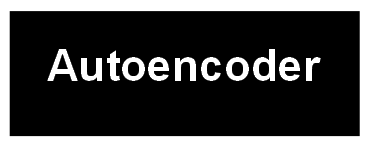

In [11]:
tf.keras.utils.plot_model(model, to_file='model.png')

## 繪製損失函數

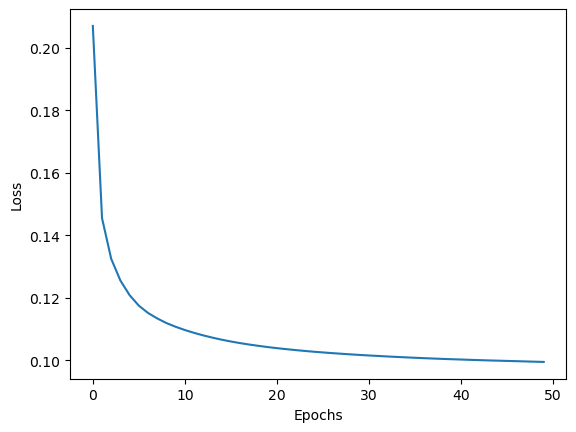

In [12]:
# 繪製損失函數
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 比較加了雜訊的圖像與訓練後的圖像

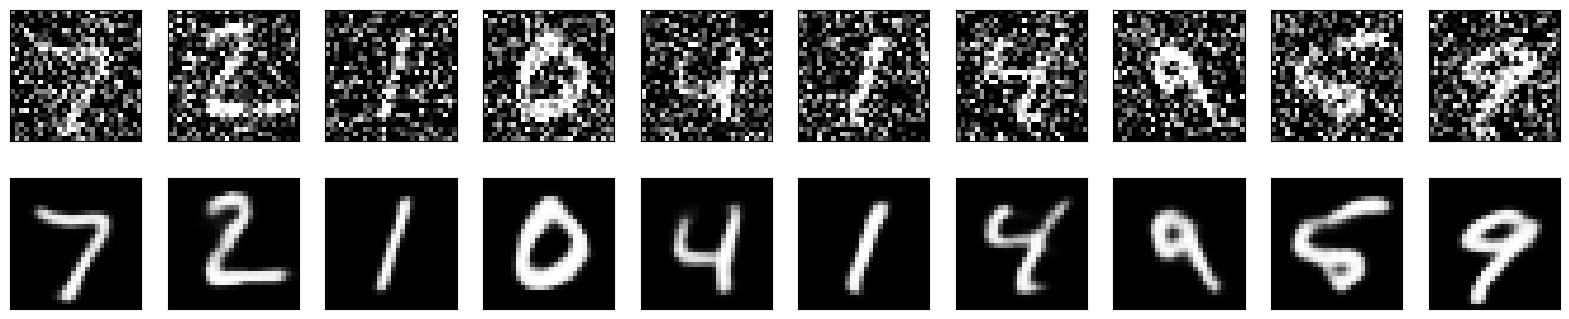

In [13]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # 加了雜訊的圖像
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重建的圖像
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(tf.reshape(model(x_test_noisy[index:index+1]), (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()